In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.gridspec import GridSpec
import datetime as dt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
cu = pd.read_csv('EDA_customer.csv')
tr = pd.read_csv('EDA_transaction_last1.csv')
pr = pd.read_csv('EDA_product_last1.csv')

In [22]:
# 가격 컬럼, order_date컬럼 생성
tr['price'] = tr['item_price'] * tr['quantity']
tr['created_at'] = pd.to_datetime(tr['created_at'])
tr['order_date'] = tr['created_at'].dt.date
tr['order_date'] = pd.to_datetime(tr['order_date'])
# df['first_join_date'] = pd.to_datetime(df['first_join_date'])

In [23]:
 # 주문주기 컬럼생성
tr = tr.sort_values(by=['customer_id', 'order_date'])
tr['date_diff'] = tr.groupby('customer_id')['order_date'].diff().dt.days
tr['date_diff'] = tr.groupby(['customer_id', 'order_date'])['date_diff'].transform('first')

In [34]:
# 주문횟수 컬럼생성
tr = tr.sort_values(['customer_id', 'order_date'])
tr['order_num'] = tr.groupby('customer_id')['order_date'].rank(method='dense').astype(int)

In [40]:
tr= pd.merge(tr, cu[['customer_id', 'first_join_date','gender','home_location']], on='customer_id', how='inner')

In [3]:
st = pd.read_csv('customer_status_NEW.csv')

In [4]:
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99878 entries, 0 to 99877
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      99878 non-null  int64 
 1   first_join_date  99878 non-null  object
 2   2017-01-01       99878 non-null  object
 3   2017-05-01       99878 non-null  object
 4   2017-09-01       99878 non-null  object
 5   2018-01-01       99878 non-null  object
 6   2018-05-01       99878 non-null  object
 7   2018-09-01       99878 non-null  object
 8   2019-01-01       99878 non-null  object
 9   2019-05-01       99878 non-null  object
 10  2019-09-01       99878 non-null  object
 11  2020-01-01       99878 non-null  object
 12  2020-05-01       99878 non-null  object
 13  2020-09-01       99878 non-null  object
 14  2021-01-01       99878 non-null  object
 15  2021-05-01       99878 non-null  object
 16  2021-09-01       99878 non-null  object
 17  2022-01-01       99878 non-null

In [5]:
# Count the number of customers for each status on 2022-01-01
customer_status_2022 = st['2022-01-01'].value_counts()

customer_status_2022

2022-01-01
low_potential_new    36715
active_existing      25034
dormant              15767
not_join_yet         14166
inactive_new          4749
active_new            3422
resurrected             25
Name: count, dtype: int64

In [6]:
columns_of_interest = ["2021-01-01", "2021-05-01", "2021-09-01"]

# Step 1: Count the occurrences of 'active_existing' and 'dormant' for each customer
active_existing_counts = st[columns_of_interest].apply(lambda x: (x == 'active_existing').sum(), axis=1)
dormant_counts = st[columns_of_interest].apply(lambda x: (x == 'dormant').sum(), axis=1)

# Step 2: Determine the current status for each customer based on the counts
current_status = ['active_existing' if ae > d else 'dormant' if d > 0 else 'none' for ae, d in zip(active_existing_counts, dormant_counts)]

# Filter out 'none' status (Step 3)
status_df = pd.DataFrame({"customer_id": st["customer_id"], "current_status": current_status})
filtered_status_df = status_df[status_df["current_status"] != "none"]

# Count the number of customers for each determined current status
status_counts = filtered_status_df["current_status"].value_counts()

status_counts


current_status
active_existing    21348
dormant            15440
Name: count, dtype: int64

In [7]:
cc = pd.read_csv('customer_class2.csv')

In [8]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49244 entries, 0 to 49243
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  49244 non-null  int64 
 1   RFM_Segment  49244 non-null  object
 2   RFM_Score    49244 non-null  int64 
 3   RFM_class    49244 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [9]:
# Merge the two datasets based on "customer_id"
merged_data = pd.merge(st, cc, on="customer_id", how="inner")

# Display the first few rows of the merged data
merged_data.head()

,customer_id,first_join_date,2017-01-01,2017-05-01,2017-09-01,2018-01-01,2018-05-01,2018-09-01,2019-01-01,2019-05-01,...,2020-05-01,2020-09-01,2021-01-01,2021-05-01,2021-09-01,2022-01-01,2022-05-01,RFM_Segment,RFM_Score,RFM_class
0,7279,2020-08-23,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,...,not_join_yet,active_new,active_existing,active_existing,active_existing,active_existing,active_existing,4.04.04.0,12,platinum
1,82542,2021-04-11,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,...,not_join_yet,not_join_yet,not_join_yet,active_new,dormant,dormant,dormant,1.01.01.0,3,silver
2,96453,2022-01-09,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,...,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,active_new,3.01.01.0,5,silver
3,8031,2019-09-12,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,...,dormant,active_existing,dormant,dormant,active_existing,dormant,dormant,2.02.04.0,8,gold
4,9152,2019-11-21,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,not_join_yet,...,dormant,dormant,active_existing,dormant,dormant,active_existing,dormant,2.02.01.0,5,silver


In [13]:
columns_2017 = ["2017-01-01", "2017-05-01", "2017-09-01"]
columns_2018 = ["2018-01-01", "2018-05-01", "2018-09-01"]
columns_2019 = ["2019-01-01", "2019-05-01", "2019-09-01"]
columns_2020 = ["2020-01-01", "2020-05-01", "2020-09-01"]
columns_2021 = ["2021-01-01", "2021-05-01", "2021-09-01"]
years = ["2017", "2018", "2019", "2020", "2021"]


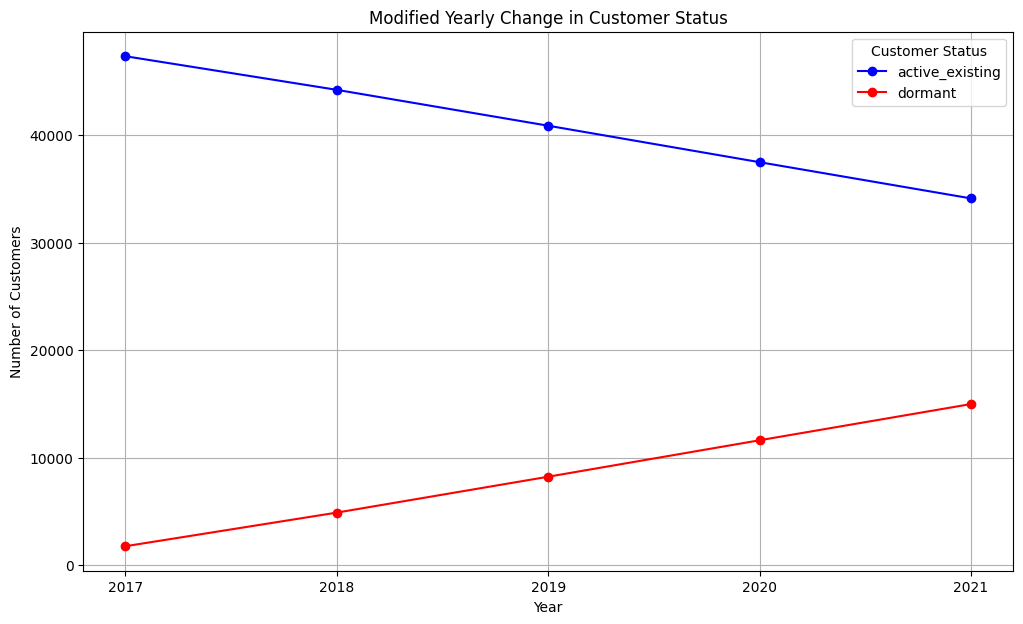

In [14]:
def modified_yearly_status(data, columns):
    active_existing_count = (data[columns] == 'active_existing').sum(axis=1)
    dormant_count = (data[columns] == 'dormant').sum(axis=1)
    
    # Determine the status based on priority between 'active_existing' and 'dormant'
    status = np.where(
        active_existing_count >= dormant_count, 
        'active_existing', 
        'dormant'
    )
    
    return status

# Calculate the yearly status for each year based on the modified function
merged_data['2017_status'] = modified_yearly_status(merged_data, columns_2017)
merged_data['2018_status'] = modified_yearly_status(merged_data, columns_2018)
merged_data['2019_status'] = modified_yearly_status(merged_data, columns_2019)
merged_data['2020_status'] = modified_yearly_status(merged_data, columns_2020)
merged_data['2021_status'] = modified_yearly_status(merged_data, columns_2021)

# Count the statuses for each year
modified_yearly_status_counts = merged_data[['2017_status', '2018_status', '2019_status', '2020_status', '2021_status']].apply(lambda x: x.value_counts()).T

# Plotting the modified yearly status counts
colors = ['blue', 'red']
plt.figure(figsize=(12, 7))
modified_yearly_status_counts.plot(kind='line', marker='o', color=colors, ax=plt.gca())
plt.title("Modified Yearly Change in Customer Status")
plt.ylabel("Number of Customers")
plt.xlabel("Year")
plt.xticks(ticks=np.arange(5), labels=years)
plt.legend(title="Customer Status")
plt.grid(True)
plt.show()

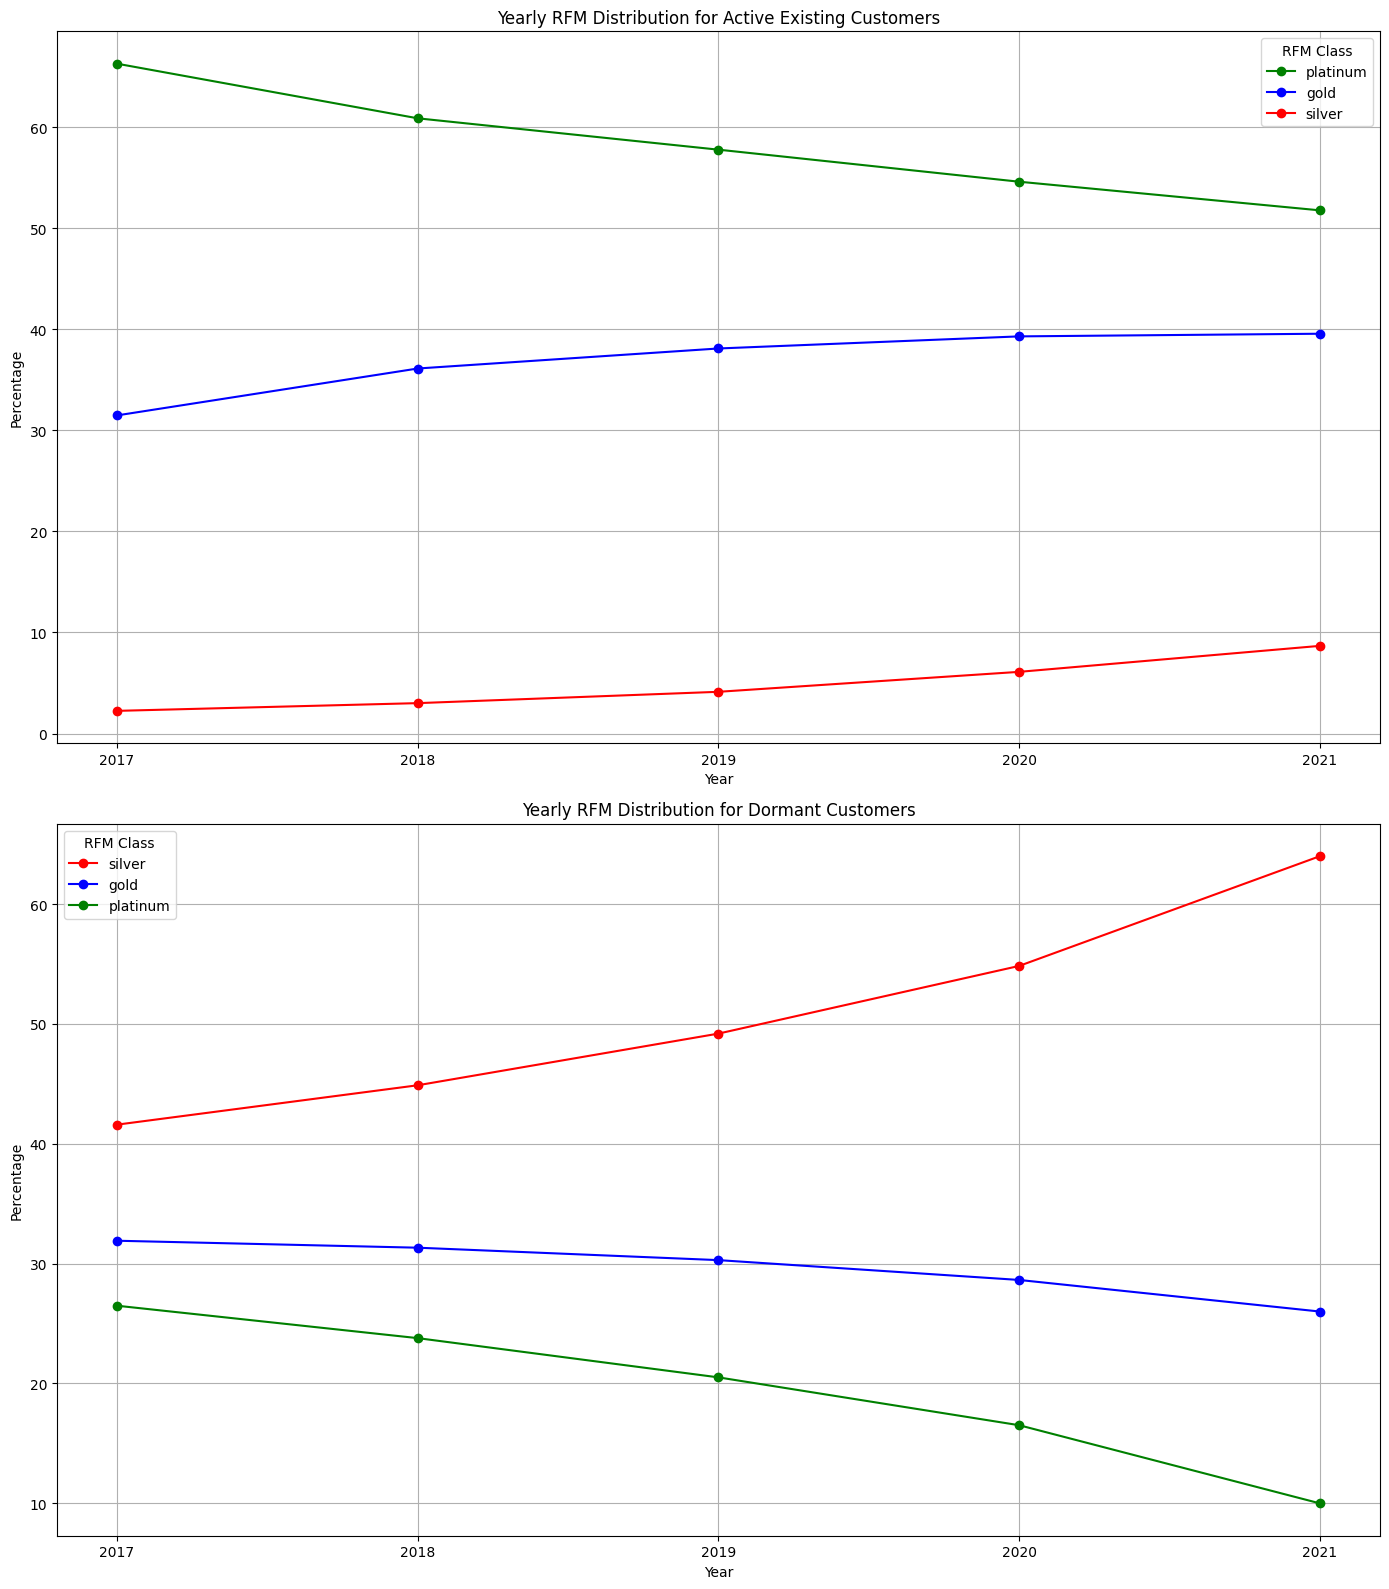

In [15]:
# Function to extract RFM distribution
def optimized_rfm_distribution_v2(data, year_columns, customer_status):
    active_counts = (data[year_columns] == 'active_existing').sum(axis=1)
    dormant_counts = (data[year_columns] == 'dormant').sum(axis=1)
    status = np.where(active_counts > dormant_counts, 'active_existing', 'dormant')
    filtered_customers = data[status == customer_status]
    return filtered_customers['RFM_class'].value_counts(normalize=True) * 100

# Extracting RFM distributions
rfm_distributions_active_v2 = {year: optimized_rfm_distribution_v2(merged_data, columns, 'active_existing') for year, columns in zip(years, [columns_2017, columns_2018, columns_2019, columns_2020, columns_2021])}
rfm_distributions_dormant_v2 = {year: optimized_rfm_distribution_v2(merged_data, columns, 'dormant') for year, columns in zip(years, [columns_2017, columns_2018, columns_2019, columns_2020, columns_2021])}

# Transforming the data for plotting
df_rfm_distribution_active_v2 = pd.DataFrame(rfm_distributions_active_v2).T.fillna(0)
df_rfm_distribution_dormant_v2 = pd.DataFrame(rfm_distributions_dormant_v2).T.fillna(0)

# Defining the colors
rfm_colors = {
    "platinum": "green",
    "gold": "blue",
    "silver": "red",
}

# Plotting the data
fig, axes = plt.subplots(2, 1, figsize=(14, 16))
df_rfm_distribution_active_v2.plot(ax=axes[0], kind='line', marker='o', color=[rfm_colors[col] for col in df_rfm_distribution_active_v2.columns])
axes[0].set_title("Yearly RFM Distribution for Active Existing Customers")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Year")
axes[0].set_xticks(np.arange(5))
axes[0].set_xticklabels(years)
axes[0].legend(title="RFM Class")
axes[0].grid(True)

df_rfm_distribution_dormant_v2.plot(ax=axes[1], kind='line', marker='o', color=[rfm_colors[col] for col in df_rfm_distribution_dormant_v2.columns])
axes[1].set_title("Yearly RFM Distribution for Dormant Customers")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Year")
axes[1].set_xticks(np.arange(5))
axes[1].set_xticklabels(years)
axes[1].legend(title="RFM Class")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [16]:
# Modifying the function to reference the correct column name for RFM class
def get_customer_ids_for_conditions(data, year_columns, status_condition, class_condition):
    """Extract customer IDs based on status and RFM class conditions."""
    active_counts = (data[year_columns] == 'active_existing').sum(axis=1)
    dormant_counts = (data[year_columns] == 'dormant').sum(axis=1)
    status = np.where(active_counts > dormant_counts, 'active_existing', 'dormant')
    
    return data[(status == status_condition) & (data['RFM_class'] == class_condition)]['customer_id'].values

# Extracting customer IDs again using the correct column name
active_platinum_ids_2021_v2 = get_customer_ids_for_conditions(merged_data, columns_2021, 'active_existing', 'platinum')
active_gold_ids_2021_v2 = get_customer_ids_for_conditions(merged_data, columns_2021, 'active_existing', 'gold')
active_silver_ids_2021_v2 = get_customer_ids_for_conditions(merged_data, columns_2021, 'active_existing', 'silver')
dormant_platinum_ids_2021_v2 = get_customer_ids_for_conditions(merged_data, columns_2021, 'dormant', 'platinum')
dormant_gold_ids_2021_v2 = get_customer_ids_for_conditions(merged_data, columns_2021, 'dormant', 'gold')
dormant_silver_ids_2021_v2 = get_customer_ids_for_conditions(merged_data, columns_2021, 'dormant', 'silver')

len(active_platinum_ids_2021_v2), len(active_gold_ids_2021_v2), len(active_silver_ids_2021_v2), len(dormant_platinum_ids_2021_v2), len(dormant_gold_ids_2021_v2), len(dormant_silver_ids_2021_v2)


(11051, 8445, 1852, 2776, 7222, 17776)

- 분석대상정리
    - active_gold_ids_2021_v2 : active에서 증가가 뚜렷한
    - active_silver_ids_2021_v2 : 이것도 같이 비교???
    - dormant_silver_ids_2021_v2 : dormant에서 증가가 뚜렷한

In [17]:
dormant_silver_ids_2021_v2

array([82542, 96453,  9152, ..., 64054, 34566, 38690], dtype=int64)

In [41]:
dormant_silver = tr[tr['customer_id'].isin(dormant_silver_ids_2021_v2)]
dormant_silver.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51505 entries, 87 to 1254584
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   created_at           51505 non-null  datetime64[ns, UTC]
 1   customer_id          51505 non-null  int64              
 2   session_id           51505 non-null  object             
 3   payment_method       51505 non-null  object             
 4   payment_status       51505 non-null  object             
 5   promo_amount         51505 non-null  int64              
 6   promo_code           51505 non-null  object             
 7   shipment_fee         51505 non-null  int64              
 8   shipment_date_limit  51505 non-null  object             
 9   total_amount         51505 non-null  int64              
 10  product_id           51505 non-null  int64              
 11  quantity             51505 non-null  int64              
 12  item_price          

In [26]:
dormant_silver['date_diff'].mean()

243.46729708431837

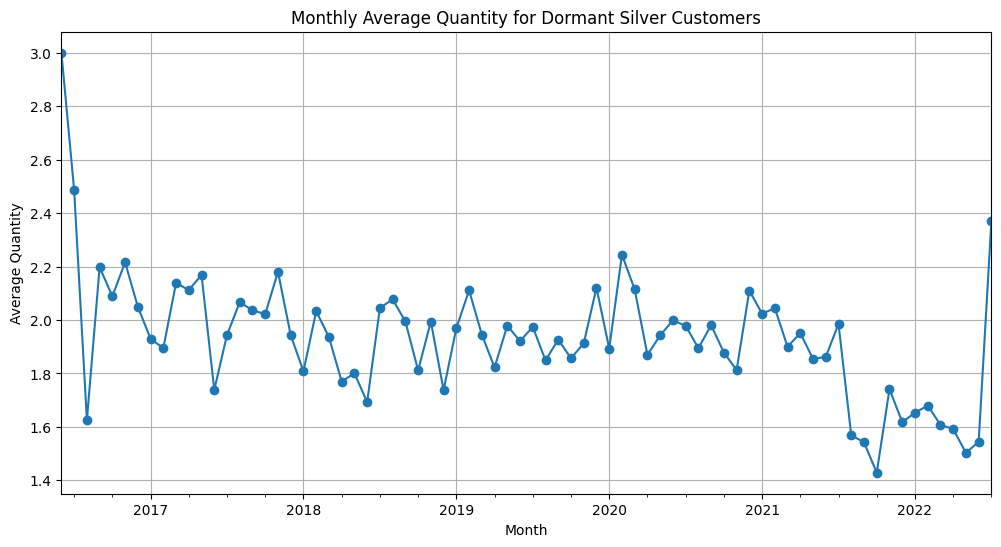

In [29]:
# Extracting month information from order_date
dormant_silver['month'] = pd.to_datetime(dormant_silver['order_date']).dt.to_period('M')

# Grouping by session_id and calculating the sum of quantity
session_quantity_sum = dormant_silver.groupby('session_id')['quantity'].sum().reset_index()

# Merging the monthly information back to the session data
session_monthly = dormant_silver[['session_id', 'month']].drop_duplicates().merge(session_quantity_sum, on='session_id')

# Calculating the monthly average of quantity
monthly_avg_quantity = session_monthly.groupby('month')['quantity'].mean()

# Plotting the monthly average quantity
monthly_avg_quantity.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Monthly Average Quantity for Dormant Silver Customers")
plt.xlabel("Month")
plt.ylabel("Average Quantity")
plt.grid(True)
plt.show()


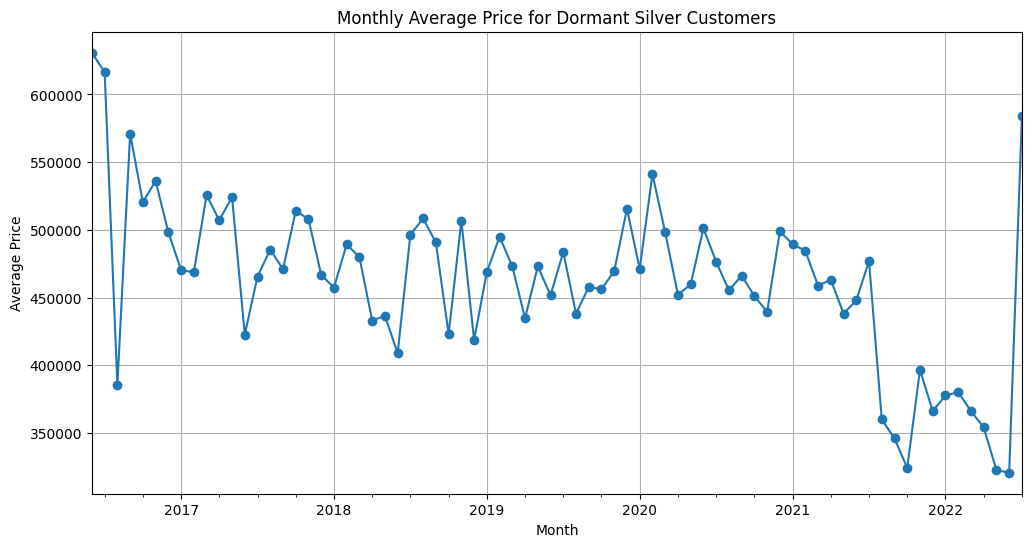

In [31]:
# Grouping by session_id and calculating the sum of price
session_price_sum = dormant_silver.groupby('session_id')['price'].sum().reset_index()

# Extracting month from order_date and merging the monthly information back to the session data
dormant_silver['month'] = pd.to_datetime(dormant_silver['order_date']).dt.to_period('M')
session_monthly_price = dormant_silver[['session_id', 'month']].drop_duplicates().merge(session_price_sum, on='session_id')

# Calculating the monthly average of price
monthly_avg_price = session_monthly_price.groupby('month')['price'].mean()

# Plotting the monthly average price
monthly_avg_price.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Monthly Average Price for Dormant Silver Customers")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.grid(True)
plt.show()

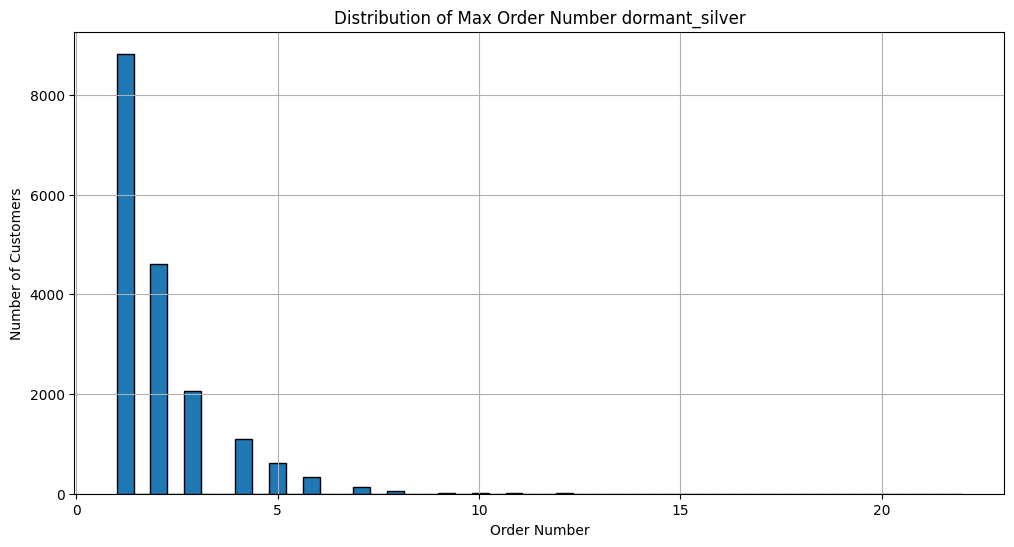

In [37]:
# Find the max order_num for each customer_id
max_order_nums = dormant_silver.groupby('customer_id')['order_num'].max()

# Plotting the distribution
plt.figure(figsize=(12, 6))
max_order_nums.hist(bins=50, edgecolor='black')
plt.title('Distribution of Max Order Number dormant_silver')
plt.xlabel('Order Number')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

In [42]:
active_silver = tr[tr['customer_id'].isin(active_silver_ids_2021_v2)]
active_silver.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16191 entries, 88 to 1254462
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   created_at           16191 non-null  datetime64[ns, UTC]
 1   customer_id          16191 non-null  int64              
 2   session_id           16191 non-null  object             
 3   payment_method       16191 non-null  object             
 4   payment_status       16191 non-null  object             
 5   promo_amount         16191 non-null  int64              
 6   promo_code           16191 non-null  object             
 7   shipment_fee         16191 non-null  int64              
 8   shipment_date_limit  16191 non-null  object             
 9   total_amount         16191 non-null  int64              
 10  product_id           16191 non-null  int64              
 11  quantity             16191 non-null  int64              
 12  item_price          

In [28]:
active_silver['date_diff'].mean()

153.82921838766882

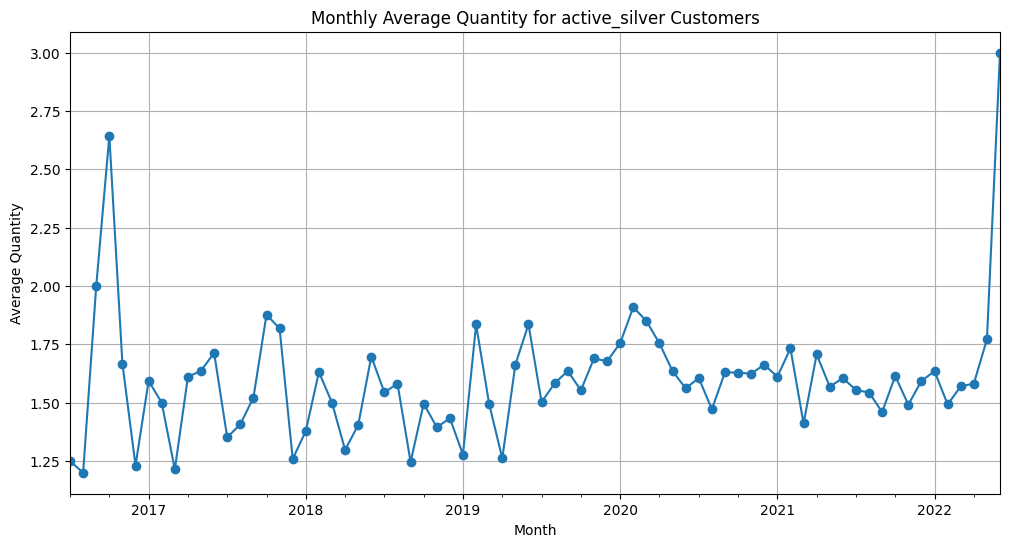

In [30]:
# Extracting month information from order_date
active_silver['month'] = pd.to_datetime(active_silver['order_date']).dt.to_period('M')

# Grouping by session_id and calculating the sum of quantity
session_quantity_sum = active_silver.groupby('session_id')['quantity'].sum().reset_index()

# Merging the monthly information back to the session data
session_monthly = active_silver[['session_id', 'month']].drop_duplicates().merge(session_quantity_sum, on='session_id')

# Calculating the monthly average of quantity
monthly_avg_quantity = session_monthly.groupby('month')['quantity'].mean()

# Plotting the monthly average quantity
monthly_avg_quantity.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Monthly Average Quantity for active_silver Customers")
plt.xlabel("Month")
plt.ylabel("Average Quantity")
plt.grid(True)
plt.show()

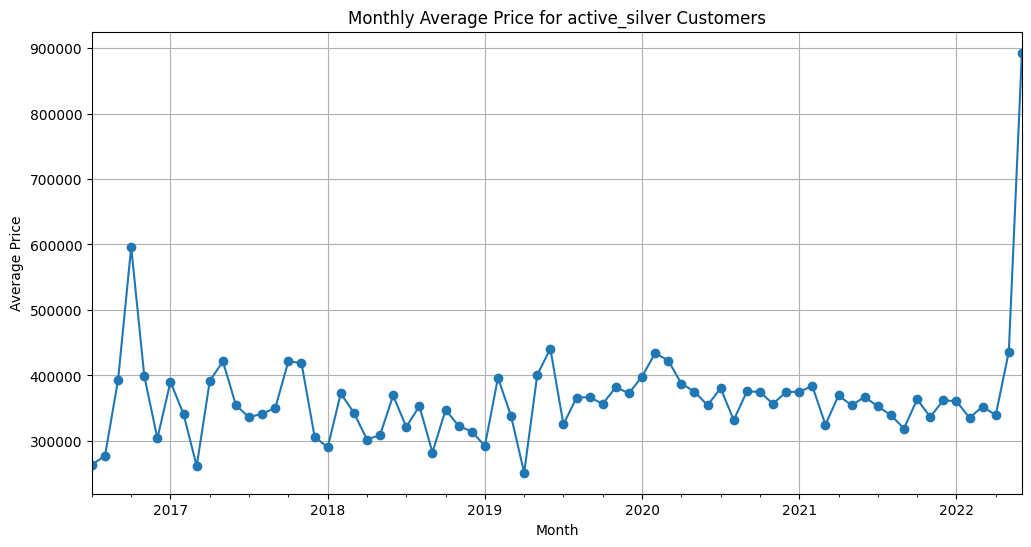

In [33]:
# Grouping by session_id and calculating the sum of price
session_price_sum = active_silver.groupby('session_id')['price'].sum().reset_index()

# Extracting month from order_date and merging the monthly information back to the session data
active_silver['month'] = pd.to_datetime(active_silver['order_date']).dt.to_period('M')
session_monthly_price = active_silver[['session_id', 'month']].drop_duplicates().merge(session_price_sum, on='session_id')

# Calculating the monthly average of price
monthly_avg_price = session_monthly_price.groupby('month')['price'].mean()

# Plotting the monthly average price
monthly_avg_price.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Monthly Average Price for active_silver Customers")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.grid(True)
plt.show()


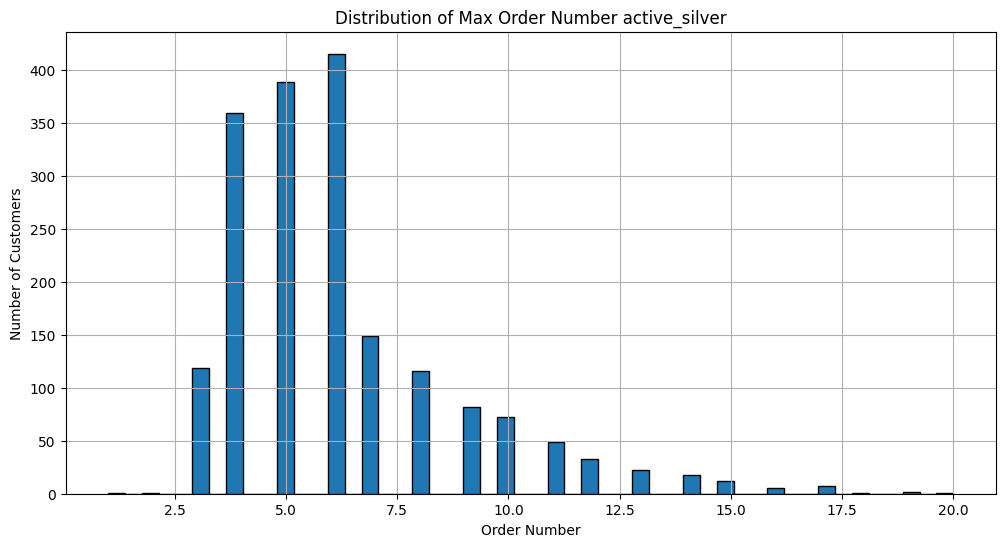

In [39]:
# Find the max order_num for each customer_id
max_order_nums = active_silver.groupby('customer_id')['order_num'].max()

# Plotting the distribution
plt.figure(figsize=(12, 6))
max_order_nums.hist(bins=50, edgecolor='black')
plt.title('Distribution of Max Order Number active_silver')
plt.xlabel('Order Number')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()